<a href="https://colab.research.google.com/github/shizoda/education/blob/main/image/PixelsInImage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🖼️ デジタル画像の基礎

このノートブックは、デジタル画像の基本的な概念を実践的に学ぶためのものです。コンピュータが画像をどのように「見て」いるのか、つまり「数値の集まり」としてどう扱っているのかを理解することを目的とします。

今回は、一枚の画像の中から特徴的な部分（ROI: Region of Interest）を自動で見つけ出し、その部分を構成するピクセルの値を実際に目で見て確認します。

## 📖 このノートブックで学べること
* Pythonを使った画像の読み込み、リサイズ、色空間の変換
* カラー画像がR (Red), G (Green), B (Blue) の3つのチャンネルから成り立つことの理解
* 「関心領域（ROI）」の概念と、その自動探索アルゴリズムの実装
    * 色の鮮やかさ（色彩情報）とコントラスト（輝度情報）を評価指標とする方法を学びます。
* 画像の特定領域を拡大し、ピクセル単位の数値データを可視化する方法

## 🛠️ ツールの使い方
このノートブックは、インタラクティブなUIを備えています。

1.  **ROI（関心領域）の設定**フォームが表示されます。
2.  **自動探索モード**
    * デフォルト（`manual_x = -1`）のままコードを実行すると、プログラムが画像内で最も特徴的だと判断した領域を自動で探し、その座標（X, Y）を出力します。
3.  **手動設定モード**
    * `manual_x`と`manual_y`に0以上の整数値を入力すると、指定した座標を左上としてROIが設定されます。自動探索で見つかった座標や、自分で試したい座標を入力して結果を比較してみましょう。

それでは、実際にコードを実行して、画像に含まれる値を確認してみましょう。


自動モードでROIを探索します...
探索結果: X=44, Y=94 にROIを自動設定しました。


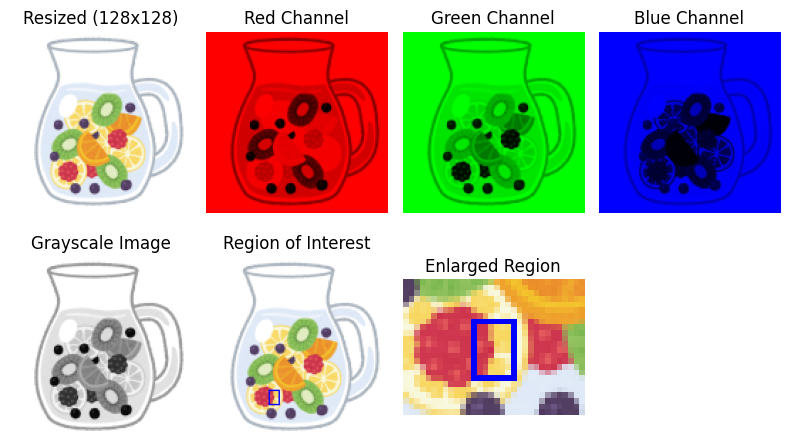

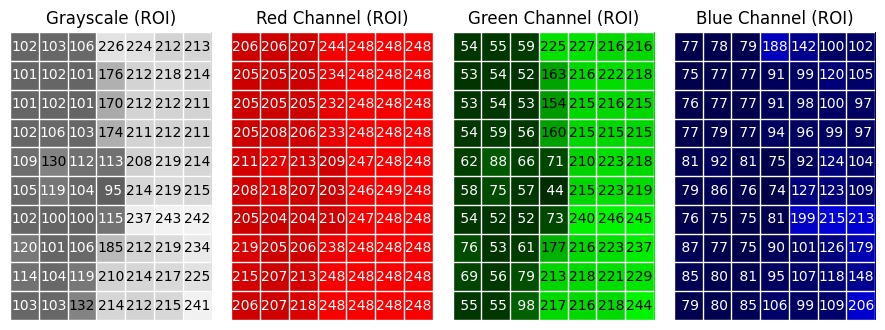

In [3]:
# @markdown ### ROI（関心領域）の設定
# @markdown `manual_x` か `manual_y` に-1を設定すると自動探索モードになります。
# @markdown 0以上の値を設定すると、その座標がROIの左上隅として手動で設定されます。
# @markdown ---
manual_x = -1  # @param {type:"integer"}
manual_y = -1  # @param {type:"integer"}
manual_width = 7  # @param {type:"integer"}
manual_height = 10 # @param {type:"integer"}

import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from matplotlib.colors import LinearSegmentedColormap

# 画像のダウンロード
url = "https://raw.githubusercontent.com/shizoda/education/refs/heads/main/sample/irasutoya_drink.png"
image_path = "/tmp/downloaded_image.png"

try:
    with urllib.request.urlopen(url) as response, open(image_path, 'wb') as f:
        f.write(response.read())
except Exception as e:
    print(f"画像のダウンロードに失敗しました。エラー: {e}")
    exit()

# 画像の読み込み (アルファチャンネルを保持)
image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

if image is None:
    print("画像の読み込みに失敗しました。")
    exit()

# アルファチャンネルがある場合、透明部分を白に変換
if image.shape[2] == 4:
    alpha_channel = image[:,:,3]
    image[alpha_channel == 0] = [255, 255, 255, 255]

# BGR/BGRAからRGBに変換
if image.shape[2] == 4:
    image_rgb_orig = cv2.cvtColor(image, cv2.COLOR_BGRA2RGB)
else:
    image_rgb_orig = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 画像を128x128にリサイズ
target_size = (128, 128)
image_rgb = cv2.resize(image_rgb_orig, target_size, interpolation=cv2.INTER_AREA)

# グレースケール変換
gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)

# --- ROIの決定ロジック ---
final_x, final_y, final_w, final_h = 0, 0, manual_width, manual_height

if manual_x < 0 or manual_y < 0:
    print("自動モードでROIを探索します...")
    # ▼▼▼ バランス調整用の重み ▼▼▼
    w_color = 3.0
    w_variance = 10.0

    best_x, best_y = -1, -1
    max_combined_score = -1

    scan_width = image_rgb.shape[1] - final_w
    scan_height = image_rgb.shape[0] - final_h

    if scan_width >= 0 and scan_height >= 0:
        for y in range(scan_height):
            for x in range(scan_width):
                roi_rgb = image_rgb[y:y+final_h, x:x+final_w]

                # 1. カラフルさのスコア
                roi_r = roi_rgb[:, :, 0].astype(np.int16)
                roi_g = roi_rgb[:, :, 1].astype(np.int16)
                roi_b = roi_rgb[:, :, 2].astype(np.int16)
                color_diff_score = np.sum(np.abs(roi_r - roi_g)) + \
                                   np.sum(np.abs(roi_g - roi_b)) + \
                                   np.sum(np.abs(roi_b - roi_r))

                # 2. 明るさの分散スコア
                roi_gray = gray[y:y+final_h, x:x+final_w]
                variance_score = np.var(roi_gray)

                # 3. 最終スコア
                combined_score = (w_color * color_diff_score) + (w_variance * variance_score)

                if combined_score > max_combined_score:
                    max_combined_score = combined_score
                    best_x, best_y = x, y

        final_x, final_y = best_x, best_y
        print(f"探索結果: X={final_x}, Y={final_y} にROIを自動設定しました。")
    else:
        print("画像サイズが探索領域より小さいため、自動探索をスキップしました。")

else:
    print(f"手動モード: X={manual_x}, Y={manual_y} にROIを設定します。")
    final_x, final_y = manual_x, manual_y

# --- ここから後続の処理 ---
# 座標が画像の範囲外にならないように補正
final_x = max(0, min(final_x, image_rgb.shape[1] - final_w))
final_y = max(0, min(final_y, image_rgb.shape[0] - final_h))

# 見つかった領域を矩形で囲む
image_with_rect = image_rgb.copy()
cv2.rectangle(image_with_rect, (final_x, final_y), (final_x + final_w, final_y + final_h), (0, 0, 255), 1)

# 拡大する部分の座標
roi_gray = gray[final_y:final_y+final_h, final_x:final_x+final_w]
roi_r = image_rgb[final_y:final_y+final_h, final_x:final_x+final_w, 0]
roi_g = image_rgb[final_y:final_y+final_h, final_x:final_x+final_w, 1]
roi_b = image_rgb[final_y:final_y+final_h, final_x:final_x+final_w, 2]

# (以下、グラフ描画のコードは変更なし)
# ... (ピクセル値プロット用の関数やカスタムカラーマップ定義) ...

# ピクセル値を文字として表示し、格子を描画する汎用関数
def show_channel_with_grid_and_values(ax, data, title, cmap='gray', vmin=0, vmax=255):
    ax.imshow(data, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.axis("off")
    # 格子を描画
    for i in range(data.shape[0] + 1):
        ax.axhline(i - 0.5, color='white', lw=1)
    for j in range(data.shape[1] + 1):
        ax.axvline(j - 0.5, color='white', lw=1)
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            # テキストの色を濃度値に応じて変更
            if "Red Channel" in title: text_color = "white"  # if data[i, j] <= 230 else "black"
            elif "Blue Channel" in title: text_color = "white"
            else: text_color = "white" if data[i, j] < 128 else "black"
            ax.text(j, i, f"{data[i, j]:3}", ha="center", va="center", color=text_color, fontsize=10)

# カスタムカラーマップを定義
cdict_red = {'red':   ((0.0, 0.0, 0.0), (1.0, 1.0, 1.0)), 'green': ((0.0, 0.0, 0.0), (1.0, 0.0, 0.0)), 'blue':  ((0.0, 0.0, 0.0), (1.0, 0.0, 0.0))}
Red_cmap = LinearSegmentedColormap('Red_cmap', segmentdata=cdict_red, N=256)
cdict_green = {'red':   ((0.0, 0.0, 0.0), (1.0, 0.0, 0.0)), 'green': ((0.0, 0.0, 0.0), (1.0, 1.0, 1.0)), 'blue':  ((0.0, 0.0, 0.0), (1.0, 0.0, 0.0))}
Green_cmap = LinearSegmentedColormap('Green_cmap', segmentdata=cdict_green, N=256)
cdict_blue = {'red':   ((0.0, 0.0, 0.0), (1.0, 0.0, 0.0)), 'green': ((0.0, 0.0, 0.0), (1.0, 0.0, 0.0)), 'blue':  ((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))}
Blue_cmap = LinearSegmentedColormap('Blue_cmap', segmentdata=cdict_blue, N=256)

# --- グラフ描画 ---
# 1. 全体像のプロット
fig = plt.figure(figsize=(8, 7))

ax1 = fig.add_subplot(3, 4, 1)
ax1.imshow(image_rgb)
ax1.set_title(f"Resized ({target_size[0]}x{target_size[1]})")
ax1.axis("off")

ax4 = fig.add_subplot(3, 4, 2)
ax4.imshow(image_rgb[:,:,0], cmap=Red_cmap)
ax4.set_title("Red Channel")
ax4.axis("off")

ax5 = fig.add_subplot(3, 4, 3)
ax5.imshow(image_rgb[:,:,1], cmap=Green_cmap)
ax5.set_title("Green Channel")
ax5.axis("off")

ax6 = fig.add_subplot(3, 4, 4)
ax6.imshow(image_rgb[:,:,2], cmap=Blue_cmap)
ax6.set_title("Blue Channel")
ax6.axis("off")

ax2 = fig.add_subplot(3, 4, 5)
ax2.imshow(gray, cmap='gray')
ax2.set_title("Grayscale Image")
ax2.axis("off")

ax3 = fig.add_subplot(3, 4, 6)
ax3.imshow(image_with_rect)
ax3.set_title("Region of Interest")
ax3.axis("off")

# 拡大している領域の周囲 32x24 画素を切り出し表示
enlarged_w, enlarged_h = 32, 24
enlarged_x = max(0, final_x - (enlarged_w - final_w) // 2)
enlarged_y = max(0, final_y - (enlarged_h - final_h) // 2)
roi_enlarged = image_with_rect[enlarged_y:enlarged_y+enlarged_h, enlarged_x:enlarged_x+enlarged_w]
ax7 = fig.add_subplot(3, 4, 7)
ax7.imshow(roi_enlarged)
ax7.set_title(f"Enlarged Region")
ax7.axis("off")

plt.tight_layout()
plt.show()

# 2. ROIの詳細プロット
fig, axes = plt.subplots(1, 4, figsize=(9, 4))
show_channel_with_grid_and_values(axes[3], roi_b, "Blue Channel (ROI)", cmap=Blue_cmap)
show_channel_with_grid_and_values(axes[2], roi_g, "Green Channel (ROI)", cmap=Green_cmap)
show_channel_with_grid_and_values(axes[1], roi_r, "Red Channel (ROI)", cmap=Red_cmap)
show_channel_with_grid_and_values(axes[0], roi_gray, "Grayscale (ROI)")
plt.tight_layout()
plt.show()

---
## ✅ まとめ
このノートブックでは、画像の中から「色の変化が豊かで、かつ明暗がはっきりしている」という基準で特徴的な領域（ROI）を自動的に見つけ出し、そのピクセル値を可視化しました。

普段何気なく見ている画像が、コンピュータ内部ではR, G, B, グレースケールといった数値データ（0〜255の整数）の集合として処理されていることを、実際の値を見ることで直感的に理解できたかと思います。

このような特定領域の数値パターンを解析する技術は、単純ながらも非常に強力であり、あらゆる高度な画像処理やコンピュータビジョン技術の基礎となっています。

## 🚀 今後の発展
今回のプログラムをベースに、さらに学びを深めるためのアイデアをいくつか紹介します。

### 1. ROIの探索基準を変えてみる
自動探索のロジックで、`w_color`（色彩の重み）と`w_variance`（輝度分散の重み）のバランスを変えると、どのような領域が選ばれるか試してみましょう。
* `w_color` を `w_variance` よりずっと大きくすると？
* 逆に `w_variance` を大きくすると？
* 他の評価指標は考えられないでしょうか？（例：特定の色を持つ領域、エッジ（輪郭）が最も多い領域など）

### 2. 別の画像で試してみる
コード冒頭の`url`変数を、好きな画像のURLに変更して実行してみましょう。人物の顔、風景、アニメキャラクターなど、対象によってアルゴリズムがどのような領域を選択するか観察すると面白い発見があるかもしれません。

### 3. 機械学習への応用
今回のように画像から特定の特徴（色、コントラストなど）を数値として抽出する処理は、「特徴量エンジニアリング」と呼ばれ、古典的な機械学習における非常に重要なステップです。
近年主流の深層学習（特にCNN）では、モデルがこのような特徴量をデータから自動で学習しますが、その裏側では同様の計算が複雑に組み合わさって行われています。